# **Amazon review data - Kindle (e-books) store**

Data source: http://jmcauley.ucsd.edu/data/amazon/

## Imports

In [1]:
import math
import findspark
import numpy as np
from itertools import chain
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

sns.set(color_codes=True)

/home/xavier/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from pyspark.sql import SparkSession

findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()

# I- Data exploration

## 1/ Data loading

In [3]:
json = spark.read.json("./data/reviews_Kindle_Store_5.json.gz")
print("Number of rows:", json.count())
json.show(10)

Number of rows: 982619
+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|      asin|helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|B000F83SZQ| [0, 0]|    5.0|I enjoy vintage b...| 05 5, 2014|A1F6404F1VG29J|          Avidreader|  Nice vintage story|    1399248000|
|B000F83SZQ| [2, 2]|    4.0|This book is a re...| 01 6, 2014| AN0N05A9LIJEQ|            critters|        Different...|    1388966400|
|B000F83SZQ| [2, 2]|    4.0|This was a fairly...| 04 4, 2014| A795DMNCJILA6|                 dot|               Oldie|    1396569600|
|B000F83SZQ| [1, 1]|    5.0|I'd never read an...|02 19, 2014|A1FV0SX13TWVXQ|Elaine H. Turley ...|  I really liked it.|    1392768000|
|B000F83SZQ| [0, 1]|    4.0|If you like

We keep 3 columns : user id, ebook id and rating.

In [4]:
data = json.select("reviewerID", "asin", "overall")
data.show(10)
data.cache()

+--------------+----------+-------+
|    reviewerID|      asin|overall|
+--------------+----------+-------+
|A1F6404F1VG29J|B000F83SZQ|    5.0|
| AN0N05A9LIJEQ|B000F83SZQ|    4.0|
| A795DMNCJILA6|B000F83SZQ|    4.0|
|A1FV0SX13TWVXQ|B000F83SZQ|    5.0|
|A3SPTOKDG7WBLN|B000F83SZQ|    4.0|
|A1RK2OCZDSGC6R|B000F83SZQ|    4.0|
|A2HSAKHC3IBRE6|B000F83SZQ|    4.0|
|A3DE6XGZ2EPADS|B000F83SZQ|    4.0|
|A1UG4Q4D3OAH3A|B000FA64PA|    5.0|
| AQZH7YTWQPOBE|B000FA64PA|    4.0|
+--------------+----------+-------+
only showing top 10 rows



DataFrame[reviewerID: string, asin: string, overall: double]

## 2/ Data exploration

In [5]:
print("Number of ratings: ", data.count())
print("Number of ebooks:", data.select("asin").distinct().count())
print("Number of reviewers:", data.select("reviewerID").distinct().count())

Number of ratings:  982619
Number of ebooks: 61934
Number of reviewers: 68223


Number or ratings per ebook:

+----------+-----+
|      asin|count|
+----------+-----+
|B006GWO5WK| 1113|
|B00BTIDW4S|  781|
|B00BT0J8ZS|  516|
|B00JDYC5OI|  502|
|B00H0V069M|  481|
|B00BTIDXVU|  454|
|B00BSX4U04|  452|
|B00BTIDOO6|  428|
|B007R5YDYA|  422|
|B005DOK8NW|  408|
+----------+-----+



[(0, 200)]

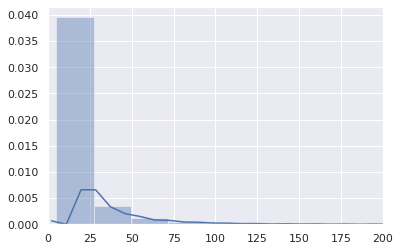

In [6]:
json.groupBy("asin").count().sort('count', ascending=False).limit(10).show()
df = json.groupBy("asin").count().sort('count', ascending=False).toPandas()
fig = sns.distplot(df['count'].values);
fig.set(xlim=(0, 200))

Number of ratings per reviewers:

+--------------+--------------------+-----+
|    reviewerID|        reviewerName|count|
+--------------+--------------------+-----+
|A13QTZ8CIMHHG4|LAS Reviewer "The...| 1173|
|A2WZJDFX12QXKD|       Stuart Powell| 1007|
| A320TMDV6KCFU|                MNix|  846|
|A3PTWPKPXOG8Y5|              Alexis|  789|
|A1JLU5H1CCENWX|        andrewsheath|  781|
|A37LY77Q2YPJVL|        Cathy Wilson|  744|
|A3A7FF87LEVCQ1|  morehumanthanhuman|  655|
|A2JZCZYHNQHSCP|         James Irwin|  625|
|A328S9RN3U5M68|          Grady Harp|  587|
| A2YJ8VP1SSHJ7|           NFerguson|  578|
+--------------+--------------------+-----+



[(0, 200)]

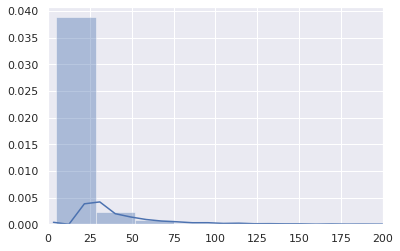

In [7]:
json.groupBy("reviewerID", "reviewerName").count().sort('count', ascending=False).limit(10).show()
df = json.groupBy("reviewerID").count().sort('count', ascending=False).toPandas()
fig = sns.distplot(df['count'].values);
fig.set(xlim=(0, 200))

Distribution of ratings between 0 to 5:

+-------+------+
|overall| count|
+-------+------+
|    5.0|575264|
|    4.0|254013|
|    3.0| 96194|
|    2.0| 34130|
|    1.0| 23018|
+-------+------+



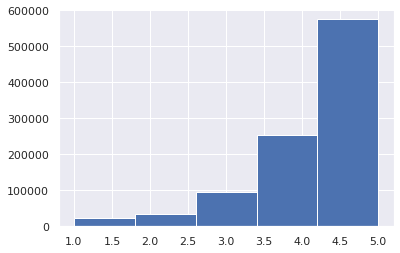

In [8]:
json.groupBy("overall").count().sort('count', ascending=False).limit(10).show()
df = json.select("overall").toPandas()
df.overall.hist(bins=5)

# II- Recommender system based on similarities among users

## 1/ Data reduction

The number of data makes the calculations slow on Spark locally so we choose to reduce the number. We can later use the initial data by skipping these code portions.

We remove the users who gave few ratings:

In [9]:
treshold = 20
small_users = data.groupby('reviewerID').count().filter(col("count") < treshold)
print("Number of reviewers who rated less than ", treshold, " ebooks: ", small_users.count())
data = data.join(small_users, "reviewerID", "left_anti")
print("New number of ratings:", data.count())

Number of reviewers who rated less than  20  ebooks:  57625
New number of ratings: 507714


We remove the ebooks with the fewest ratings:

In [10]:
rare_ebooks = data.groupby('asin').count().filter(col("count") < treshold)
print("Number of ebooks with less than ", treshold, " ratings: ", rare_ebooks.count())
data = data.join(rare_ebooks, "asin", "left_anti")
print("New number of ratings:", data.count())

Number of ebooks with less than  20  ratings:  55515
New number of ratings: 170739


Data remaining:

In [11]:
nb_reviewers = data.select("reviewerID").distinct().count()
print("Number of ratings: ", data.count())
print("Number of ebooks:", data.select("asin").distinct().count())
print("Number of reviewers:", nb_reviewers)

Number of ratings:  170739
Number of ebooks: 4825
Number of reviewers: 10163


## 2/ Data formatting


We create the dataframe *userRatings* with 2 columns: *reviewerID* and *ratings*:

In [12]:
# Create the dataframe userRatings with 2 cols: "reviewerID" and "ratings" (the list of the ebooks the user rated and the rating)
userRatings = data.withColumn("rates", struct("asin", "overall")).groupby("reviewerID").agg(F.collect_list("rates").alias("ratings"))
userRatings.show(5)
data.unpersist()
userRatings.cache()

+--------------+--------------------+
|    reviewerID|             ratings|
+--------------+--------------------+
|A1F0DP938FCEEW|[[B00H0V069M, 5.0...|
|A2TNY4OUWVTJ0F|[[B00FFLU4LE, 2.0...|
|A1CNQTCRQ35IMM|[[B00G8U2O0U, 3.0...|
|A1NLWXTRON9H0P|[[B00HCT48DM, 5.0...|
|A3PN9XIW1I85MG|[[B00EDDC0NK, 5.0...|
+--------------+--------------------+
only showing top 5 rows



DataFrame[reviewerID: string, ratings: array<struct<asin:string,overall:double>>]

We compute the number of ratings per user:

In [13]:
def count_ratings(x):
    """ Return the number of ratings given by a user"""
    return int(len(x))

udf_count_ratings = udf(count_ratings, IntegerType())

userRatings = userRatings.withColumn("number_ratings", udf_count_ratings("ratings"))
userRatings = userRatings.orderBy("number_ratings", ascending=False)
userRatings.show()

+--------------+--------------------+--------------+
|    reviewerID|             ratings|number_ratings|
+--------------+--------------------+--------------+
|A1JLU5H1CCENWX|[[B00FFLU4LE, 5.0...|           441|
| A2YJ8VP1SSHJ7|[[B007YN8IGE, 5.0...|           307|
|A3IQ0P3M39IY8U|[[B008LX70HE, 5.0...|           231|
| ALY4MQYVAEE4U|[[B00H0V069M, 5.0...|           219|
|A2VXSQHJWZAQGY|[[B00EBSOLFW, 3.0...|           185|
|A1ENV91MFAEVA3|[[B00H0V069M, 5.0...|           184|
| AW4NFCPN81CS3|[[B00FKERXXS, 4.0...|           174|
|A3KBRXW4PKK2MT|[[B00HCMZZQ8, 5.0...|           174|
|A3U41P3MHAEXYU|[[B00FFLU4LE, 3.0...|           173|
|A1JKGTL51HHTU1|[[B00COU1A7G, 4.0...|           171|
|A1BQO66R6OLCCW|[[B00HFAGOM6, 5.0...|           169|
| AD9HAE7DPTQDG|[[B003VYC776, 4.0...|           168|
|A3A7FF87LEVCQ1|[[B005J5CZHW, 1.0...|           168|
| A3LXRIY0HE71K|[[B00H0V069M, 5.0...|           167|
|A3GWE80SUGORJD|[[B00ET55NGS, 5.0...|           163|
|A1O79BLZSTP53I|[[B008BP0BQE, 5.0...|         

In [14]:
print("Schema:")
userRatings.printSchema()

Schema:
root
 |-- reviewerID: string (nullable = true)
 |-- ratings: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- asin: string (nullable = true)
 |    |    |-- overall: double (nullable = true)
 |-- number_ratings: integer (nullable = true)



## 3/ Similarities between users

In this part we calculate a similarity coefficient between each user and a reference user (user Y).

First, we prepare the data of the user Y:

In [15]:
USER_Y = "A1JLU5H1CCENWX"

In [16]:
def ratings_of_one_user(reviewerID):
    """ List the ebooks and associated ratings given by the user with the id reviewerID. Returns a column containing a dict: {"bookID": "rating"}"""
    user = userRatings.where(col("reviewerID") == reviewerID)
    ratings = user.collect()[0].ratings

    user_ratings = dict()
    for item in ratings:
        user_ratings[item.asin] = item.overall

    col_user_ratings = create_map([lit(x) for x in chain(*user_ratings.items())])
    return col_user_ratings

user_Y_ratings = ratings_of_one_user(USER_Y)

We compute the number of common rated ebooks between user x and user y:

In [17]:
def count_simil(x, y1):
    """ Count the number of common rated ebooks between user x and user y"""
    # Changement de format des données
    x = [i for i in x]
    x1 = dict()
    for item in x:
        x1[item.asin] = item.overall

    # common: livres notés en commun
    common = x1.keys() & y1.keys()
    return len(common)
    
udf_count_simil = udf(count_simil, IntegerType())

userRatings = userRatings.withColumn('common_ratings', udf_count_simil('ratings', user_Y_ratings))
userRatings = userRatings.orderBy("common_ratings", ascending=False)
userRatings.show()

+--------------+--------------------+--------------+--------------+
|    reviewerID|             ratings|number_ratings|common_ratings|
+--------------+--------------------+--------------+--------------+
|A1JLU5H1CCENWX|[[B00FFLU4LE, 5.0...|           441|           441|
|A1ENV91MFAEVA3|[[B00H0V069M, 5.0...|           184|            61|
| ALY4MQYVAEE4U|[[B00H0V069M, 5.0...|           219|            52|
|A3KM84RAZA7XXC|[[B00H0V069M, 5.0...|           157|            49|
|A1O5BMIWBH4OG2|[[B00FMHPXFS, 5.0...|           124|            40|
|A21HD9GWN5OHDZ|[[B00HCMZZQ8, 5.0...|            71|            38|
|A3361XGKYF17S3|[[B00FFLU4LE, 5.0...|           115|            38|
|A2RYT2UPEQXUAV|[[B00H0V069M, 5.0...|           129|            38|
|A3JCJ0PRFLNHYP|[[B00GNRGP2G, 5.0...|           115|            35|
|A1HAX9F7HY0D5V|[[B00IGGCCUQ, 4.0...|           125|            35|
|A3W3XC01BFJJMR|[[B00FFLU4LE, 3.0...|           132|            35|
| AFLUSKCVBJ8UG|[[B00FFLU4LE, 2.0...|           

Let x and y be two users. We note:<br />
— *rated* the set of ebooks rated by both users x and y<br />
— *ratX* the ratings of x on those ebooks<br />
— *ratY* the ratings of y on those ebooks<br />
We then define the similarity between users x and y as:<br />

$simil(x, y) = \frac{\sum_{m \in rated}(rating(x, m) - mean(ratX)) \times rating(y, m) - mean(ratY))}
{(variance(ratX) \times variance(ratY))^{0.5}}
\times log(1 + rated)$

The similarity is based on [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) modified to take into account the number of rated items (the $log(1 + rated)$ factor avoids spurious correlations). Note that for true recommendation we set $simil(x, x) = 0$ so that our recommendation system is not polluted by auto recommendation.

We compute the number of ebooks rated in common between each user and user Y:

We compute the similarity between each user and user Y. A negative similarity means a global opposite opinion:

In [18]:
def compute_simil(x, y1):
    """ Compute similarity between user x and y (negative simil means a global opposite opinion) """
    # Changement de format des données
    x = [i for i in x]
    x1 = dict()
    for item in x:
        x1[item.asin] = item.overall
    
    # On conserve uniquement les ebooks en commun
    common = x1.keys() & y1.keys()
    x_ratings = [x1[c] for c in common]
    y_ratings = [y1[c] for c in common]
    if len(common) == 0:
        return 0.0

    # Calcul de la note moyenne et de la variance pour chaque utilisateur
    x_mean = np.mean(x_ratings)
    y_mean = np.mean(y_ratings)
    x_var = np.var(x_ratings) * len(x_ratings) 
    y_var = np.var(y_ratings) * len(y_ratings)
    if x_var * y_var == 0:
        return 0.0
    
    # Calcul de la similarité
    tmp = 0
    for i in range(len(x_ratings)):
        tmp += (x_ratings[i] - x_mean) * (y_ratings[i] - y_mean)
        
    return float(math.log(len(common)+1)*tmp / ((x_var * y_var)**0.5))
    
    
udf_compute_simil = udf(compute_simil, DoubleType())

userRatings = userRatings.withColumn('simil', udf_compute_simil('ratings', user_Y_ratings))
# On met la similarité de l'utilisateur Y avec lui-même à 0
userRatings = userRatings.withColumn('simil', when(col("reviewerID") == USER_Y, 0.0).otherwise(col("simil")))
userRatings = userRatings.orderBy("simil", ascending=False)
userRatings.show()

+--------------+--------------------+--------------+--------------+------------------+
|    reviewerID|             ratings|number_ratings|common_ratings|             simil|
+--------------+--------------------+--------------+--------------+------------------+
|A1WBGIL46NUFFU|[[B00H0V069M, 5.0...|            39|            13|2.4904821780308013|
|A3BZXCM7XQ7XHN|[[B00G8U2O0U, 5.0...|            32|            10|2.3978952727983707|
|A163XZU3HM4EHV|[[B00K9V2OPE, 5.0...|            49|             9| 2.302585092994046|
|A3OJ7P6FIV88E4|[[B00H0V069M, 5.0...|            57|            25|2.2553152042016666|
|A34F4IHXZYZ7KS|[[B00JLTRZ18, 5.0...|            29|            11|2.2013280290078576|
| A9FCO8RDJVABW|[[B00EPZUSYY, 5.0...|            59|            13| 2.158518984518651|
| ADR7NQOEU8OFL|[[B00IVSF77Y, 5.0...|            26|             7|2.0794415416798357|
|A1XA4BJ23AVBT7|[[B00G7RAM5I, 5.0...|            58|             7|2.0794415416798357|
|A3JEN29PPBLJ9P|[[B0091YHBNA, 4.0...|      

We display the statistics on the similarity coefficient (means, etc.):

In [19]:
userRatings.select("simil").describe().show()

+-------+--------------------+
|summary|               simil|
+-------+--------------------+
|  count|               10163|
|   mean|0.008626206332236635|
| stddev|  0.2320390597097268|
|    min| -1.7917594692280552|
|    max|  2.4904821780308013|
+-------+--------------------+



## 4/ Ebook recommendations for user Y

In this part we recommend ebooks to user Y from the ratings given by the other users and the similarity coefficients of these users. To do this we calculate a score (grade) for each ebook, which permits to rank them.

### Data formatting

In [20]:
ebookRatings = data.join(userRatings, on="reviewerID").select("reviewerID", "asin", "overall", "simil").orderBy('simil', ascending=False)
ebookRatings.show(10)

+--------------+----------+-------+------------------+
|    reviewerID|      asin|overall|             simil|
+--------------+----------+-------+------------------+
|A1WBGIL46NUFFU|B00KC8Q522|    5.0|2.4904821780308013|
|A1WBGIL46NUFFU|B00GT6651C|    4.0|2.4904821780308013|
|A1WBGIL46NUFFU|B00JXWO17O|    3.0|2.4904821780308013|
|A1WBGIL46NUFFU|B00JKW0680|    5.0|2.4904821780308013|
|A1WBGIL46NUFFU|B00IO545WM|    4.0|2.4904821780308013|
|A1WBGIL46NUFFU|B00AR49H2Q|    5.0|2.4904821780308013|
|A1WBGIL46NUFFU|B00JLTRZ18|    4.0|2.4904821780308013|
|A1WBGIL46NUFFU|B00JMSXEZE|    5.0|2.4904821780308013|
|A1WBGIL46NUFFU|B00G8U2O0U|    5.0|2.4904821780308013|
|A1WBGIL46NUFFU|B00H0V069M|    5.0|2.4904821780308013|
+--------------+----------+-------+------------------+
only showing top 10 rows



In [21]:
# We group for each ebook, in the ratings column, the user ids, the ratings and the similarity coefficient of each user who rated the ebook
ebookRatings = ebookRatings.withColumn("rates", struct("reviewerID", "overall", "simil")).groupby("asin").agg(F.collect_list("rates").alias("ratings"))
print("Number of ebook to rank: ", ebookRatings.count())
ebookRatings.show(10)

Number of ebook to rank:  4825
+----------+--------------------+
|      asin|             ratings|
+----------+--------------------+
|B00EPZUSYY|[[A9FCO8RDJVABW, ...|
|B00FKERXXS|[[A31L5PCBT6RSR2,...|
|B00H0V069M|[[AXM5ZEK9I7CWL, ...|
|B00K9V2OPE|[[A31L5PCBT6RSR2,...|
|B005F0WR88|[[A2TGLLUT78OR9S,...|
|B007YN8IGE|[[A1SVKXS358TXW2,...|
|B00B0J815Q|[[A11HGVNM8Q5A2O,...|
|B008LX70HE|[[AM4XZBQH36O2M, ...|
|B00F64JFXS|[[A143IV9N6HPKKB,...|
|B00I6ZXPQM|[[A125AUW6J0LGR8,...|
+----------+--------------------+
only showing top 10 rows



### Grade calculation for each ebook

The recommendation grade of an ebook $k$ for user 1 will be the average of ratings by other users ponderated by similarities between users. As in section 4.6, we don’t want this list polluted by averages computed over very few values therefore, in practice we compute the following value :

$grade(k) = \frac{\sum_{x \in rated(x)}rating(x, k)  \times  simil(x, 1)}
{\alpha + \sum_{x \in rated(x)} simil(x, 1)}$

where $\alpha \approx 0.5$ is the average value of $simil(x, 1)$.

In [22]:
def compute_grade(x):
    """ Compute the grade of an ebook for user Y, based on the simil with the other users """
    # Reshape data
    x = [i for i in x]
    x1 = dict()
    res = 0
    for item in x:
        res += item.overall * item.simil
        
    dist = 0
    for item in x:
        dist +=  item.simil
        
    return res / (0.5 + dist)

udf_compute_grade = udf(compute_grade, DoubleType())

ebookRatings2 = ebookRatings.withColumn('grade', udf_compute_grade('ratings'))
ebookRatings2 = ebookRatings2.orderBy('grade', ascending=False)
ebookRatings2.show()

+----------+--------------------+------------------+
|      asin|             ratings|             grade|
+----------+--------------------+------------------+
|B0085WGUMM|[[A1K4S4MWXI9E9M,...| 8415.059040796705|
|B00CK8CKZS|[[A179INWJ0ZLOB4,...|1482.2542559020508|
|B00DRF28C8|[[AM4XZBQH36O2M, ...| 705.5860918183162|
|B00HCMAUIQ|[[AI0FBRMXX4R8C, ...|  516.687758855012|
|B00DGYKVWE|[[A17J3U3XOZ5A4B,...| 466.5753370443711|
|B00AP7Z27Y|[[A06120993HKK17S...| 462.3666351681521|
|B00GZ9CSHS|[[A179INWJ0ZLOB4,...|450.62026780125086|
|B0092UD3GM|[[A2SRUC3I2U1CAY,...|400.37470932880166|
|B007QTTKZY|[[A3OC8ZG1S3OAVA,...| 373.1287822397704|
|B00DJF2862|[[A2SMHIVHZGSLNF,...| 289.8320493912405|
|B009WCFBJ2|[[A13H6BLWC6IGOX,...|253.48831297095262|
|B00HYE3L4W|[[A1DWI3TBD5RZ4J,...|197.45763912911318|
|B00A43ZQI4|[[AM4XZBQH36O2M, ...| 157.4631797450386|
|B00A13YLV0|[[A10K4CN7CEA3K0,...|139.14219471830756|
|B00AXHNFJS|[[A3361XGKYF17S3,...|131.73899927758555|
|B007HQ58CK|[[A10K4CN7CEA3K0,...| 114.37451612

The distribution of the scores is displayed with a histogram:

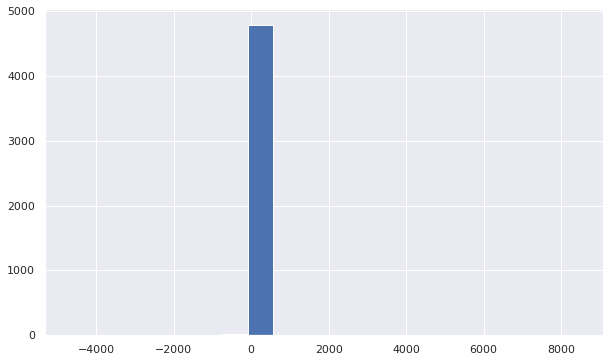

In [23]:
plt.figure(figsize=(10,6))
bins, counts = ebookRatings2.select('grade').rdd.flatMap(lambda x: x).histogram(20)
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.show()

Scores are concentrated around 0, which means that many ebooks are considered "moderately" relevant to the user. This is explained by the strong sparse nature of the data matrix; user Y has a similarity coefficient of 0 with many users and some ebooks are rated only by these users. This phenomenon is not a problem if we consider the fact of recommending only the most relevant ebooks (the first 10 for example).

### Deletion of ebooks already rated by the user

We remove from the list of recommendations the ebooks already rated by the user Y.

In [24]:
# data_user_Y: list of ebooks rated by the user
data_user_Y = data.filter(col("reviewerID") == USER_Y)
ebookRatings3 = ebookRatings2.join(data_user_Y, "asin", "left_anti") \
                             .orderBy('grade', ascending=False)
print(ebookRatings3.count())
ebookRatings3.show()

4384
+----------+--------------------+------------------+
|      asin|             ratings|             grade|
+----------+--------------------+------------------+
|B0085WGUMM|[[A1K4S4MWXI9E9M,...| 8415.059040796705|
|B00DRF28C8|[[AM4XZBQH36O2M, ...| 705.5860918183162|
|B00DGYKVWE|[[A17J3U3XOZ5A4B,...| 466.5753370443711|
|B00AP7Z27Y|[[A06120993HKK17S...| 462.3666351681521|
|B00GZ9CSHS|[[A179INWJ0ZLOB4,...|450.62026780125086|
|B0092UD3GM|[[A2SRUC3I2U1CAY,...|400.37470932880166|
|B007QTTKZY|[[A3OC8ZG1S3OAVA,...| 373.1287822397704|
|B009WCFBJ2|[[A13H6BLWC6IGOX,...|253.48831297095262|
|B00HYE3L4W|[[A1DWI3TBD5RZ4J,...|197.45763912911318|
|B00A43ZQI4|[[AM4XZBQH36O2M, ...| 157.4631797450386|
|B00A13YLV0|[[A10K4CN7CEA3K0,...|139.14219471830756|
|B007HQ58CK|[[A10K4CN7CEA3K0,...| 114.3745161286299|
|B00IXAZPX6|[[A2LH65L0AU19Q6,...|109.01564312296429|
|B007R82KLK|[[A3TGY3ANGBNK7C,...|103.70828302781196|
|B008WOUNIK|[[A2DYQLMTKM9LM8,...| 93.49792814261146|
|B00IDIFMOK|[[A2A1411NATJ6UB,...| 93.4979

### Comparison of user ratings with recommendations

We now display only the ebooks already rated by user Y, to check if the user has given a good rating to the ebooks we recommend.

In [25]:
data_user_Y = data.filter(col("reviewerID") == USER_Y)
ebookRatings4 = ebookRatings2.join(data_user_Y, "asin", "inner") \
                              .select("asin", "ratings", "grade", "overall") \
                              .orderBy('grade', ascending=False)
print("Number of ebooks rated by the user Y: ", ebookRatings4.count())
ebookRatings4.show()

Number of ebooks rated by the user Y:  441
+----------+--------------------+------------------+-------+
|      asin|             ratings|             grade|overall|
+----------+--------------------+------------------+-------+
|B00CK8CKZS|[[A179INWJ0ZLOB4,...|1482.2542559020508|    5.0|
|B00HCMAUIQ|[[AI0FBRMXX4R8C, ...|  516.687758855012|    5.0|
|B00DJF2862|[[A2SMHIVHZGSLNF,...| 289.8320493912405|    5.0|
|B00AXHNFJS|[[A3361XGKYF17S3,...|131.73899927758555|    5.0|
|B00HFUJPO0|[[A3KM84RAZA7XXC,...| 74.61728194970675|    5.0|
|B00DIGN4JC|[[A135NSTCX38DEI,...| 73.22160723880764|    5.0|
|B00IH35OY4|[[AI0FBRMXX4R8C, ...| 65.41453296775954|    5.0|
|B00AV8SY7C|[[A26GE9ZG68SKIQ,...| 38.33462077189433|    5.0|
|B00EWTJJWA|[[A2J36T6J3GWT6O,...|37.174489416520494|    5.0|
|B00H59M0NE|[[A24J97BN1RW91Q,...| 33.58156454551203|    4.0|
|B00DY8HASU|[[A34F4IHXZYZ7KS,...|27.192226008448856|    4.0|
|B00F7EBTUY|[[ACDUNU9TQ0OFF, ...|22.764721606461396|    5.0|
|B006HMDJN0|[[A6SR7U2PNGN0N, ...| 20.15756

We display the distribution of the ratings assigned by the user for the first 100 recommended ebooks:

In [26]:
ebookRatings4.limit(100).groupby("overall").count().show()

+-------+-----+
|overall|count|
+-------+-----+
|    5.0|   87|
|    4.0|   11|
|    3.0|    2|
+-------+-----+



## 5/ Comparison of similarities between users

In this part we will calculate the similarity of each user with not one but 10 users, and see if the users have the most similarity with always the same user or not.

In [27]:
userRatings2 = userRatings
users = ["A2YJ8VP1SSHJ7", "A3IQ0P3M39IY8U","ALY4MQYVAEE4U","A2VXSQHJWZAQGY","A1ENV91MFAEVA3","A3KBRXW4PKK2MT","AW4NFCPN81CS3","A3U41P3MHAEXYU", "A1JKGTL51HHTU1"]
for index, user in enumerate(users):
    user_Y_ratings = ratings_of_one_user(user) 
    col_name = "simil_" + str(index + 1)
    userRatings2 = userRatings2.withColumn(col_name, udf_compute_simil('ratings', user_Y_ratings))
    # We set the similarity of user Y with himself to 0
    userRatings2 = userRatings2.withColumn(col_name, when(col("reviewerID") == user, 0.0).otherwise(col(col_name)))
    
    col_name = "common_" + str(index + 1)
    userRatings2 = userRatings2.withColumn(col_name, udf_count_simil('ratings', user_Y_ratings))
userRatings2.show()

+--------------+--------------------+--------------+--------------+------------------+--------------------+--------+-------------------+--------+--------------------+--------+-------------------+--------+-------+--------+--------------------+--------+-------------------+--------+--------------------+--------+-------------------+--------+
|    reviewerID|             ratings|number_ratings|common_ratings|             simil|             simil_1|common_1|            simil_2|common_2|             simil_3|common_3|            simil_4|common_4|simil_5|common_5|             simil_6|common_6|            simil_7|common_7|             simil_8|common_8|            simil_9|common_9|
+--------------+--------------------+--------------+--------------+------------------+--------------------+--------+-------------------+--------+--------------------+--------+-------------------+--------+-------+--------+--------------------+--------+-------------------+--------+--------------------+--------+----------

We calculate for each user, with which user among the 10 he has the best similarity coefficient:

In [28]:
def compute_nearest(x, x1, x2, x3, x4, x5, x6, x7, x8, x9):
    x_list = [x, x1, x2, x3, x4, x5, x6, x7, x8, x9]
    x_max = np.max(x_list)
    if (x_max == 0):
        return -2
    elif (x_list.count(x_max) > 1):
        return -1
    else:
        return x_list.index(x_max)

udf_compute_nearest = udf(compute_nearest, IntegerType())

userRatings2 = userRatings2.withColumn('nearest_user', udf_compute_nearest('simil', 'simil_1', 'simil_2', 'simil_3', 'simil_4', 'simil_5', 'simil_6', 'simil_7', 'simil_8', 'simil_9'))
userRatings3 = userRatings2.drop('number_ratings', 'ratings', 'common_ratings', 'common_1', 'common_2', 'common_3', 'common_4', 'common_5', 'common_6', 'common_7', 'common_8', 'common_9')
userRatings3.show(10)

+--------------+------------------+-------+------------------+-------------------+-------+-------+------------------+------------------+-------------------+-------------------+------------+
|    reviewerID|             simil|simil_1|           simil_2|            simil_3|simil_4|simil_5|           simil_6|           simil_7|            simil_8|            simil_9|nearest_user|
+--------------+------------------+-------+------------------+-------------------+-------+-------+------------------+------------------+-------------------+-------------------+------------+
|A1WBGIL46NUFFU|2.4904821780308013|    0.0|               0.0| -1.138957039391365|    0.0|    0.0|               0.0|               0.0|                0.0|                0.0|           0|
|A3BZXCM7XQ7XHN|2.3978952727983707|    0.0|               0.0|                0.0|    0.0|    0.0|               0.0|               0.0|                0.0|                0.0|           0|
|A163XZU3HM4EHV| 2.302585092994046|    0.0|       

We list for each of the 10 users, the percentage of users who have the most similarities with them.<br />
Users with similarities with 0 of the 10 users were given the value -2, and the users with an equal similarities between multiple users were given the value -1.

In [29]:
userRatings_comp = userRatings3.groupby("nearest_user").count()
userRatings_comp = userRatings_comp.withColumn("perct_count", round(col('count') / nb_reviewers, 3)) \
                                   .orderBy("perct_count", ascending=False)
userRatings_comp.show()

+------------+-----+-----------+
|nearest_user|count|perct_count|
+------------+-----+-----------+
|          -2| 7655|      0.753|
|           2|  445|      0.044|
|           3|  322|      0.032|
|           6|  286|      0.028|
|           7|  267|      0.026|
|           4|  256|      0.025|
|           9|  247|      0.024|
|           8|  231|      0.023|
|           1|  173|      0.017|
|           0|  163|      0.016|
|           5|   63|      0.006|
|          -1|   55|      0.005|
+------------+-----+-----------+



We will count the number of ratings each 10 users have with each users:

In [31]:
userRatings4 = userRatings2.select('reviewerID', 'common_ratings', 'common_1', 'common_2', 'common_3', 'common_4', 'common_5', 'common_6', 'common_7', 'common_8', 'common_9')
userRatings4.groupBy().sum().show()

+-------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|sum(common_ratings)|sum(common_1)|sum(common_2)|sum(common_3)|sum(common_4)|sum(common_5)|sum(common_6)|sum(common_7)|sum(common_8)|sum(common_9)|
+-------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|              21007|        14322|        10989|        12755|         7947|         9245|         9311|         8579|         7838|         9271|
+-------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+



We see that the most "influential" users (users 2, 3 and 6) are not necessarily the ones with the higher number of common ratings with the other users (which are the users 0, 1, 3).

# III- Implementation of an ALS model

## 1- ALS model


In [ ]:
# dataset preparation and re-encoding of ids
asin_indexer = StringIndexer(inputCol="asin", outputCol="asinIndex")
reviewerId_indexer = StringIndexer(inputCol="reviewerID", outputCol="reviewerIdIndex")
pipeline = Pipeline(stages=[asin_indexer, reviewerId_indexer])
pip = pipeline.fit(json)
json_index = pip.transform(json)

In [ ]:
(training, test) = json_index.randomSplit([0.8, 0.2])

In [ ]:
# 1st model with default parameters
als = ALS(maxIter=5, regParam=0.01, userCol="reviewerIdIndex", itemCol="asinIndex", ratingCol="overall",
          coldStartStrategy="drop")
model = als.fit(training)
predictions = model.transform(test)

In [ ]:
# evaluation of the default model
evaluator = RegressionEvaluator(metricName="rmse", labelCol="overall",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

In [ ]:
# we recommend for all users 10 pounds
userRecs = model.recommendForAllUsers(10)
userRecs.show(10)

## 2- Improvement of the ALS model

In [ ]:
als = ALS(maxIter=5, regParam=0.01, userCol="reviewerIdIndex", itemCol="asinIndex", ratingCol="overall",
          coldStartStrategy="drop")

# .addGrid(als.nonnegative , [True, False])\
paramGrid = ParamGridBuilder()\
    .addGrid(als.maxIter , [5, 10, 20])\
    .addGrid(als.regParam , [0.01, 0.1, 1.0, 2.0])\
    .addGrid(als.rank , [5, 10, 20])\
    .build()
 
# In this case the estimator is simply the linear regression.
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(estimator=als,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

# run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(training)
predictions = model.transform(test)

In [ ]:
# display of best model parameters
print(model.bestModel.rank)
print(model.bestModel
    ._java_obj     # Get Java object
    .parent()      # Get parent (ALS estimator)
    .getRegParam())
print(model.bestModel
    ._java_obj     # Get Java object
    .parent()      # Get parent (ALS estimator)
    .getMaxIter())

In [ ]:
# model evaluation
rmse = evaluator.evaluate(predictions)
print(rmse)

In [ ]:
from pyspark.ml.fpm import FPGrowth

In [ ]:
df_fp = json.select('asin', 'reviewerID').groupby('reviewerID').agg(F.collect_list("asin"))

In [ ]:
fpGrowth = FPGrowth(itemsCol="collect_list(asin)", minSupport=0.01, minConfidence=0.1)
model_fp = fpGrowth.fit(df_fp)

In [ ]:
# display frequent itemsets.
model_fp.freqItemsets.show()

In [ ]:
model_fp.associationRules.show()

In [ ]:
df_fp.show()